In [73]:
import pandas as pd
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [138]:
simDF = pd.read_csv("../data/simRun.txt",sep=",")

In [164]:
_18kMap = hp.read_map("https://gracedb.ligo.org/api/superevents/S250818k/files/bayestar.fits.gz")
i = np.flipud(np.argsort(_18kMap))
sorted_credible_levels = np.cumsum(_18kMap[i])
credible_levels = np.empty_like(sorted_credible_levels)
credible_levels[i] = sorted_credible_levels

In [176]:
maskMap =  np.zeros_like(_18kMap)
maskMap[credible_levels<=0.9]=2
maskMap[credible_levels<=0.5]=1

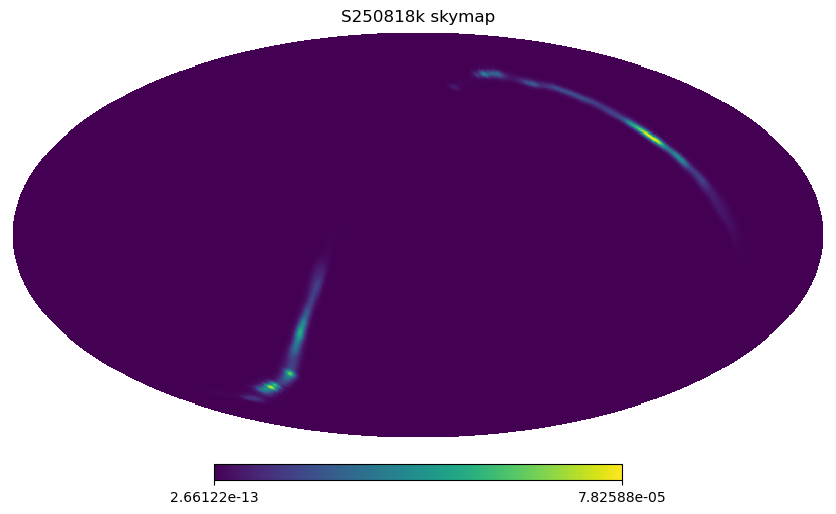

In [177]:
hp.mollview(_18kMap,title="S250818k skymap")

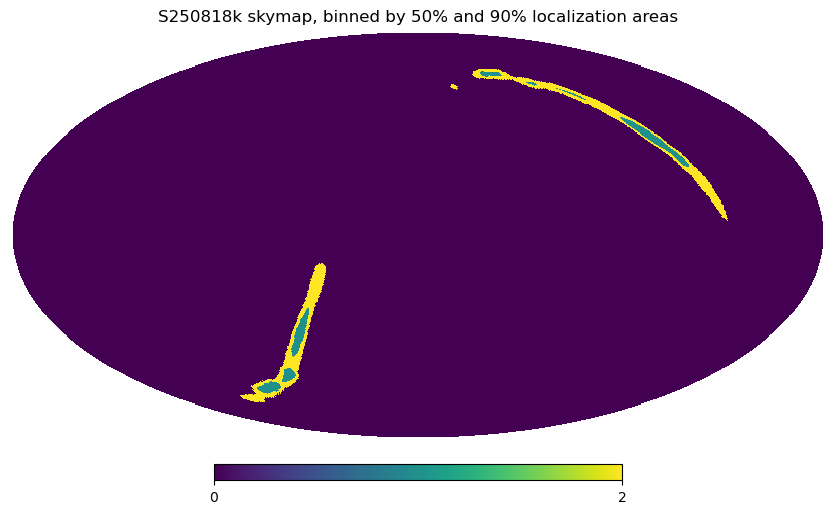

In [179]:
hp.mollview(maskMap,title="S250818k skymap, binned by 50% and 90% localization areas")

In [167]:
tot50,frac50,tot90,frac90 = 0,0,0,0

In [270]:
def getStats(mask,tile,maskFills):
    result=[]
    for fill in maskFills:
        totalOv = healpix_overlap(mask,tile,fill_value=fill)
        # print("Total: {}".format(totalOv))
        maskReg = getMaskReg(mask,fill)
        # print("maskReg: {}".format(maskReg))
        result.append(totalOv)
        result.append(totalOv/maskReg * 100)
    return result

def healpix_overlap(map1, map2, fill_value=hp.UNSEEN, nside=None, area=True):
    # Both maps should be np.ndarray of same length
    if map1.shape != map2.shape:
        raise ValueError("Maps must have the same number of pixels.")

    # Mask out fill values
    valid = (map1 == fill_value[0]) & (map2 == fill_value[1])
    
    # Count overlap
    count = len(map1[valid])

    if not area:
        return count

    # Compute area per pixel
    if nside is None:
        nside = hp.get_nside(map1)
    pix_area = hp.nside2pixarea(nside,degrees=True)  # steradians per pixel

    return count * pix_area

def getMaskReg(mask,fill):
    return hp.nside2pixarea(hp.get_nside(mask),degrees=True) * len(mask[mask==fill[0]])

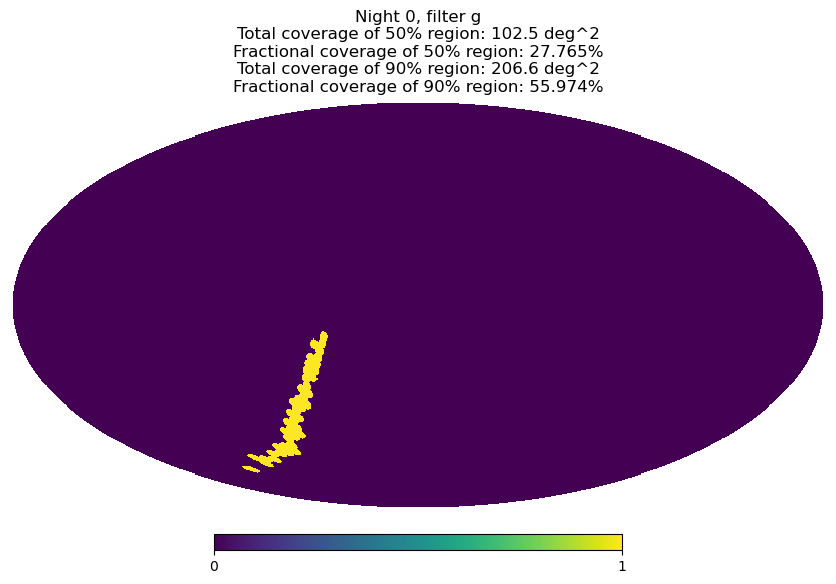

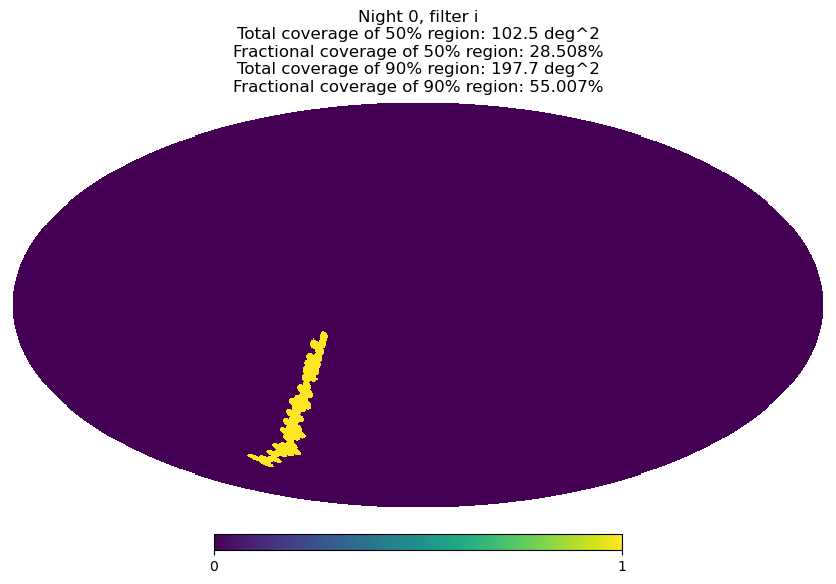

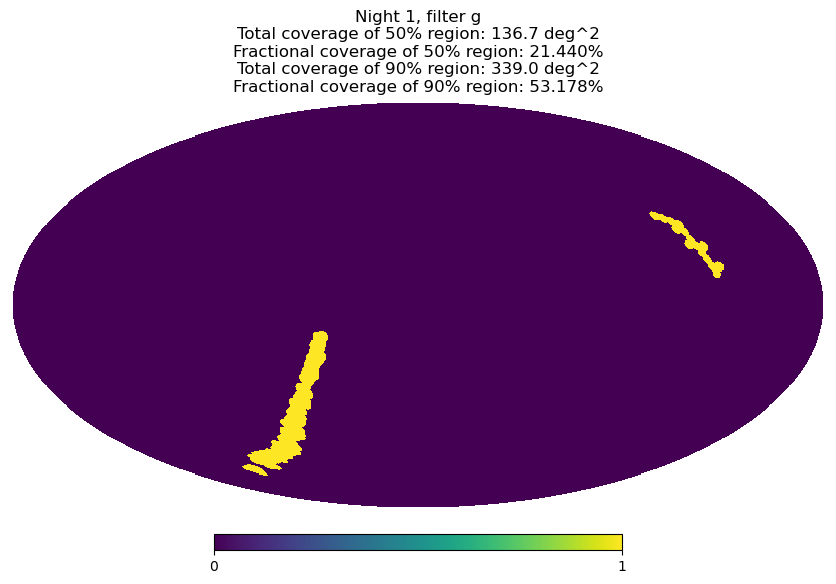

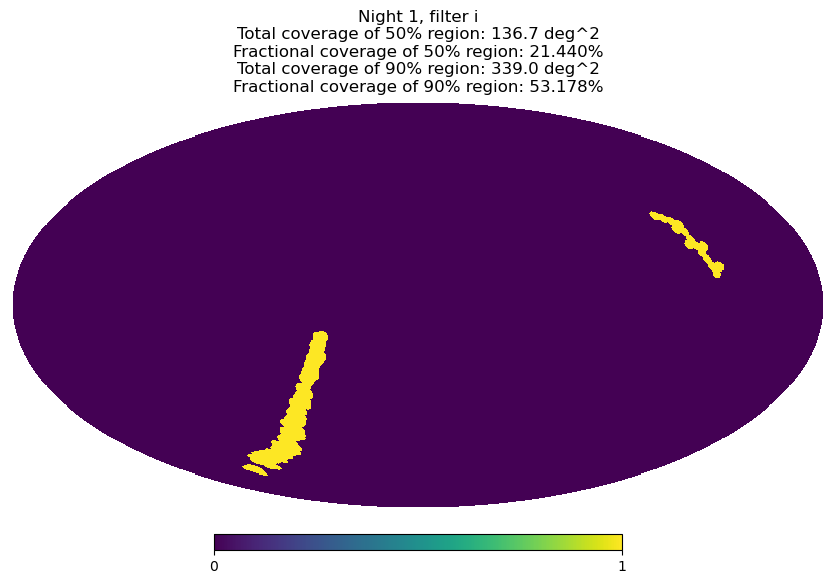

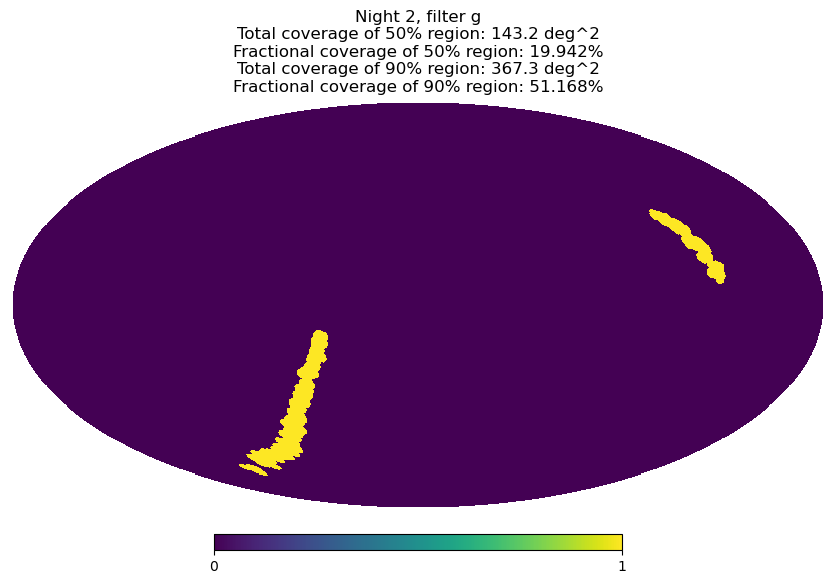

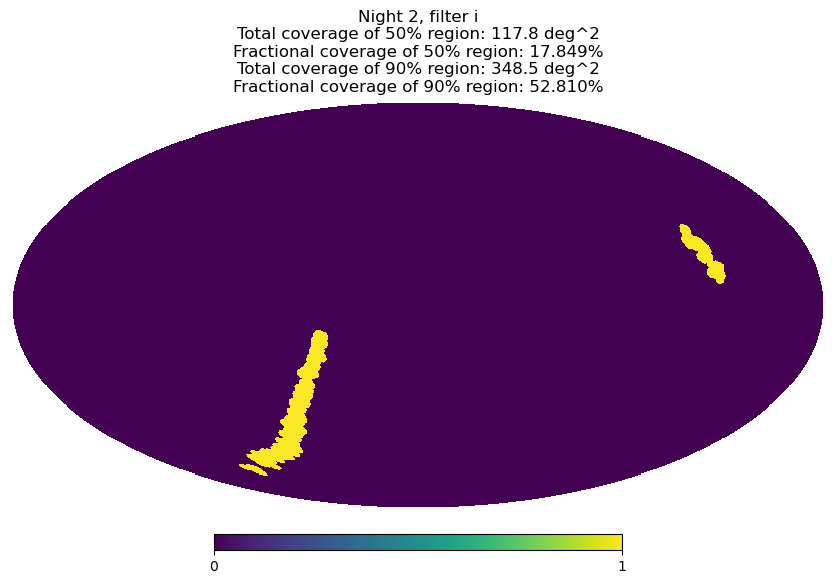

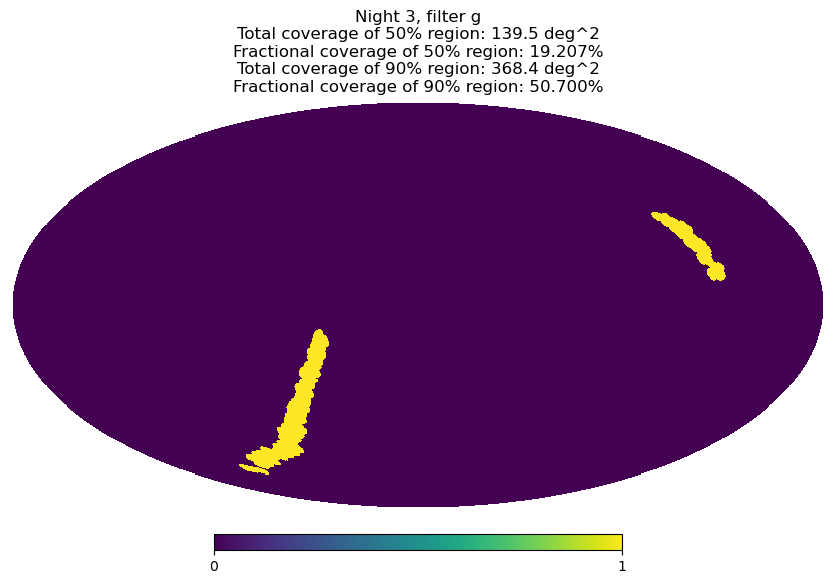

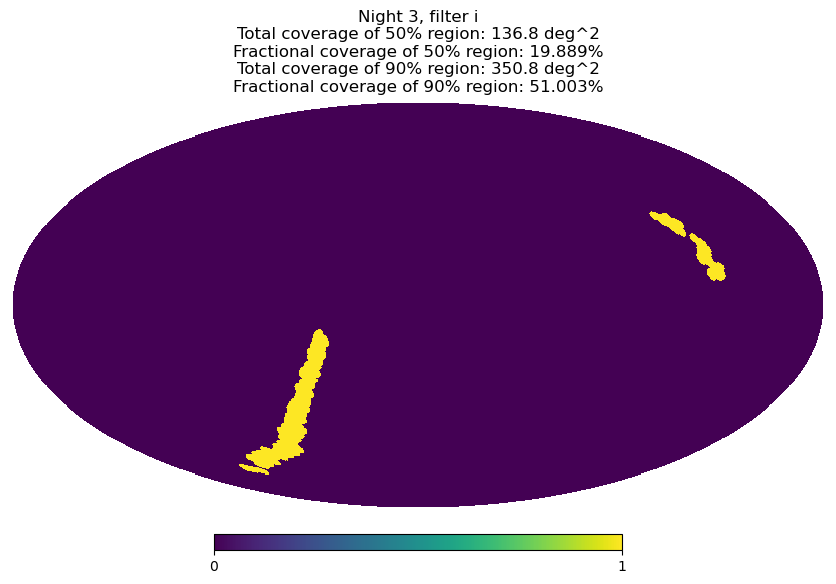

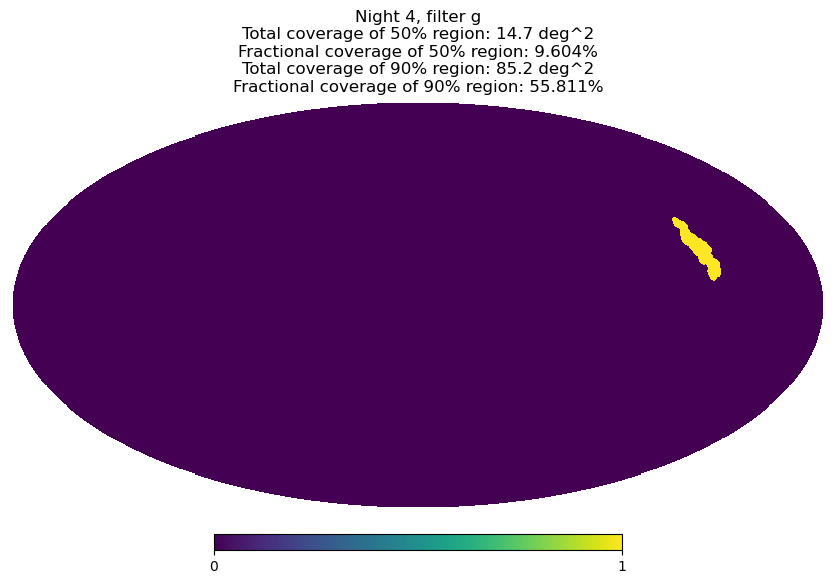

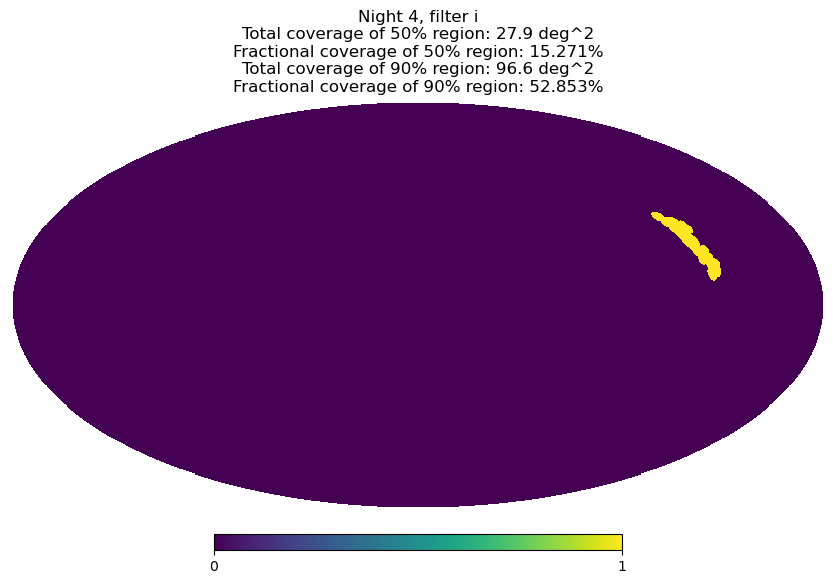

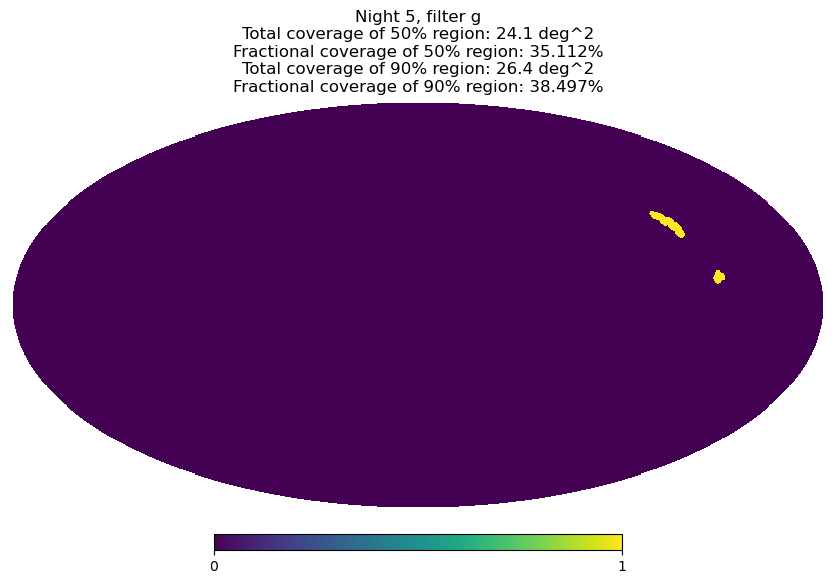

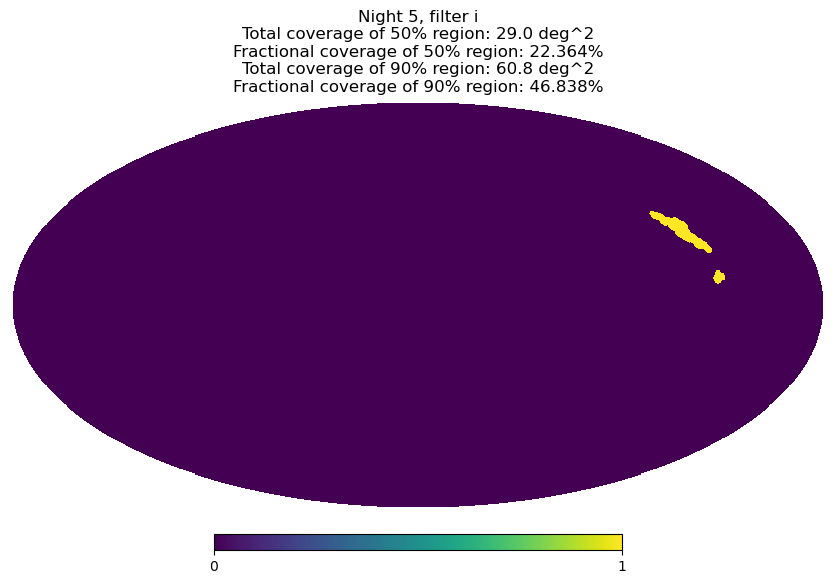

In [272]:
tot,frac=[],[]
for night in np.unique(simDF["night"]):
    nightMask = np.array(simDF['night']==night)
    for f in ["g","i"]:
        fmask = [x.__contains__(f) for x in simDF['band']]
        myMask = np.logical_and(nightMask,fmask)
        filteredDF = simDF[myMask]
        tileMap = np.zeros_like(_18kMap)
        for __,r in simDF[myMask].iterrows():
            indices = hp.query_disc(512,hp.ang2vec(-r['dec']+np.pi/2,r["RA"],lonlat=False),1.75*np.pi/180)
            tileMap[indices]=1

        # Compute statistics
        tot50,frac50,tot90,frac90 = getStats(tileMap,maskMap,[[1,1],[1,2]])
        tot.append(tot50)
        tot.append(tot90)
        frac.append(frac50)
        frac.append(frac90)
        # Make plot
        hp.mollview(tileMap,title="Night {}, filter {}\nTotal coverage of 50% region: {:.1f} deg^2\nFractional coverage of 50% region: {:.3f}%\nTotal coverage of 90% region: {:.1f} deg^2\nFractional coverage of 90% region: {:.3f}%".format(night,f,tot50,frac50,tot90,frac90))

In [277]:
tot50,tot90 = np.reshape(tot,(-1,2)).T
frac50,frac90 = np.reshape(frac,(-1,2)).T

119.58623047938485 110.13761998915601
272.8163335648517 268.3838140010802


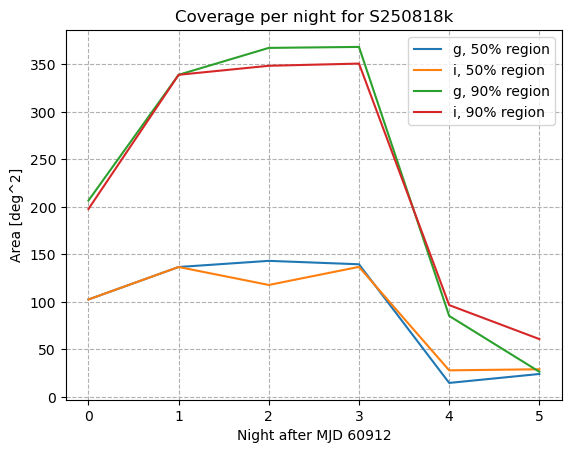

In [292]:
for d,cred in zip([tot50,tot90],["50","90"]):
    plt.plot(np.arange(len(d[0::2])),d[0::2],label="g, {}% region".format(cred))
    plt.plot(np.arange(len(d[0::2])),d[1::2],label="i, {}% region".format(cred))
    print(np.median(d[0::2]),np.median(d[1::2]))
    
plt.grid(ls="--")
plt.legend()
plt.xlabel("Night after MJD 60912")
plt.ylabel("Area [deg^2]")
plt.title("Coverage per night for S250818k")
plt.show()

20.691300778407516 20.664492970177164
52.17314136565521 52.8312169092829


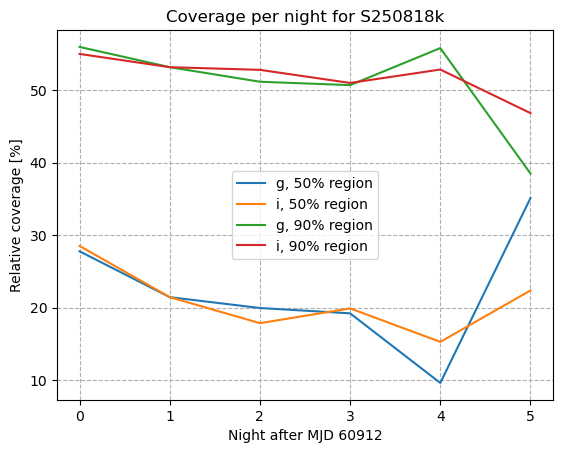

In [293]:
for d,cred in zip([frac50,frac90],["50","90"]):
    plt.plot(np.arange(len(d[0::2])),d[0::2],label="g, {}% region".format(cred))
    plt.plot(np.arange(len(d[0::2])),d[1::2],label="i, {}% region".format(cred))
    print(np.median(d[0::2]),np.median(d[1::2]))
plt.grid(ls="--")
plt.legend()
plt.xlabel("Night after MJD 60912")
plt.ylabel("Relative coverage [%]")
plt.title("Coverage per night for S250818k")
plt.show()